## 1. Importing libraries

In [248]:
from docarray import Document, DocumentArray

## 2. Configuration and setup

We'll set up some basic variables. Feel free to adapt these for your own project!

In [249]:
MAX_DOCS = 35
DATA_DIR = 'data/images'
DATA_PATH = f"{DATA_DIR}/**/*.jpg"
QUERY_IMAGE = "data/query.jpg"

Now we initiate the vector storage of the images, using Weaviate. You'll need to have a Weaviate instance running on `http://localhost:8080`. You can do that by running `docker compose up` in the terminal in this folder, using the `docker-compose.yml` file. 

DocArray supports Weaviate as a storage backend, one can use it as the follows:

In [250]:
DocumentArray(storage='weaviate', config={'host': 'localhost', 'port': '8080', 'name': 'Image'}).summary()

       Documents Summary        
                                
  Length                 31     
  Homogenous Documents   False  
                                
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

The look-and-feel of a weaviate-powered DocumentArray is exactly the same as an ordinary DocumentArray. All APIs behave the same. We will see that in the sequel.

## 3. Load Data

Now that all is set up, we can start adding the fashion images to the database. 

In [251]:
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS, storage='weaviate', config={'host': 'localhost', 'port': '8080', 'name': 'Image'})

print(f"{len(docs)} Documents in DocumentArray")


66 Documents in DocumentArray


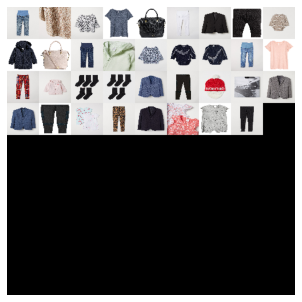

In [252]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [253]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [254]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 35                                    
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       35               False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   35               False            
  uri         ('str',)       35               False            
                                                               
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

## 5. Embed images

In [255]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [256]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [257]:
docs.embed(model, device=device)

KeyError: 'c3f8a283-4a71-58e0-ae02-d666cba81e32'

<DocumentArrayWeaviate (length=35) at 5650537056>

## 6. Query dataset

Let's query the dataset with one of the images of the dataset. We've stored this in `data/query.jpg`. Feel free to choose any jpg image of clothing as query image.

In [ ]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [ ]:
query_doc = preproc(query_doc)

In [ ]:
query_doc.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

In [ ]:
top10 = docs.find(query_doc, limit=10)

Show the result:

In [ ]:
(top10.apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()